# Optimising Munro Bagging Routes

This is testing the following algorithms to see how they perform with different sizes of datasets for the Travelling Salesman Problem (TSP)

In [1]:
## RUN THIS CELL
# This imports all the necessary modules
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import itertools
from pyCombinatorial.utils import graphs, util

In [ ]:
#Run this cell if "cartopy" not defined
!pip install cartopy

In [ ]:
#Run this cell if "pycombinatorial" is not defined
!pip install pycombinatorial

## Importing the Dataset
Using data provided from https://www.hills-database.co.uk/index.html, we can gather data and filter some of it to get the the most recent data (2021) about the Munros. 


In [2]:
munro_data = pd.read_csv("data/munro-peak-data.csv")
munro_data = np.array(munro_data)
munro_locations = munro_data[:, [14, 15]]
munro_names = munro_data[:, 5]

In [3]:
def plot_scotland_map(locations, labels = [], connected=False):
    eastings = locations[:, 0]
    northings = locations[:, 1]

    osgb_crs = ccrs.OSGB() 

    fig = plt.figure(figsize=(10, 12), dpi=200)
    ax = fig.add_subplot(1, 1, 1, projection=osgb_crs)

    #Changes size of plot based on locations provided
    buffer = 20000
    min_e = eastings.min() - buffer
    max_e = eastings.max() + buffer
    min_n = northings.min() - buffer
    max_n = northings.max() + buffer
    #Change these values to ax.set_extent([0, 450000, 550000, 1200000], crs=osgb_crs) for a map of full Scotland
    ax.set_extent([min_e, max_e, min_n, max_n], crs=osgb_crs)

    # Add map features
    ax.add_feature(cfeature.LAND, facecolor='bisque', zorder=1)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=2)
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='gray', zorder=2)

    max_size = 200
    min_size = 5
    point_size = max_size/np.sqrt(eastings.size)
    ax.scatter(eastings, northings, transform=osgb_crs, color='green', marker='^', s=max(min_size, point_size))
    
    if connected:
        ax.plot(eastings, northings, 
                transform=osgb_crs, 
                color='red', 
                linewidth=1.5, 
                linestyle='--', 
                alpha=0.7, 
                zorder=4)

    #This is for the names, comment out to remove clutter
    for i, name in enumerate(labels):
        ax.text(eastings[i]-1000, 
                northings[i]+1000, 
                f"{i+1} {name}", 
                transform=osgb_crs,          
                fontsize=3,                  
                color='black', 
                ha='left',                   
                va='bottom',                 
                zorder=4)

    plt.title('Location of Munros')
    plt.show()

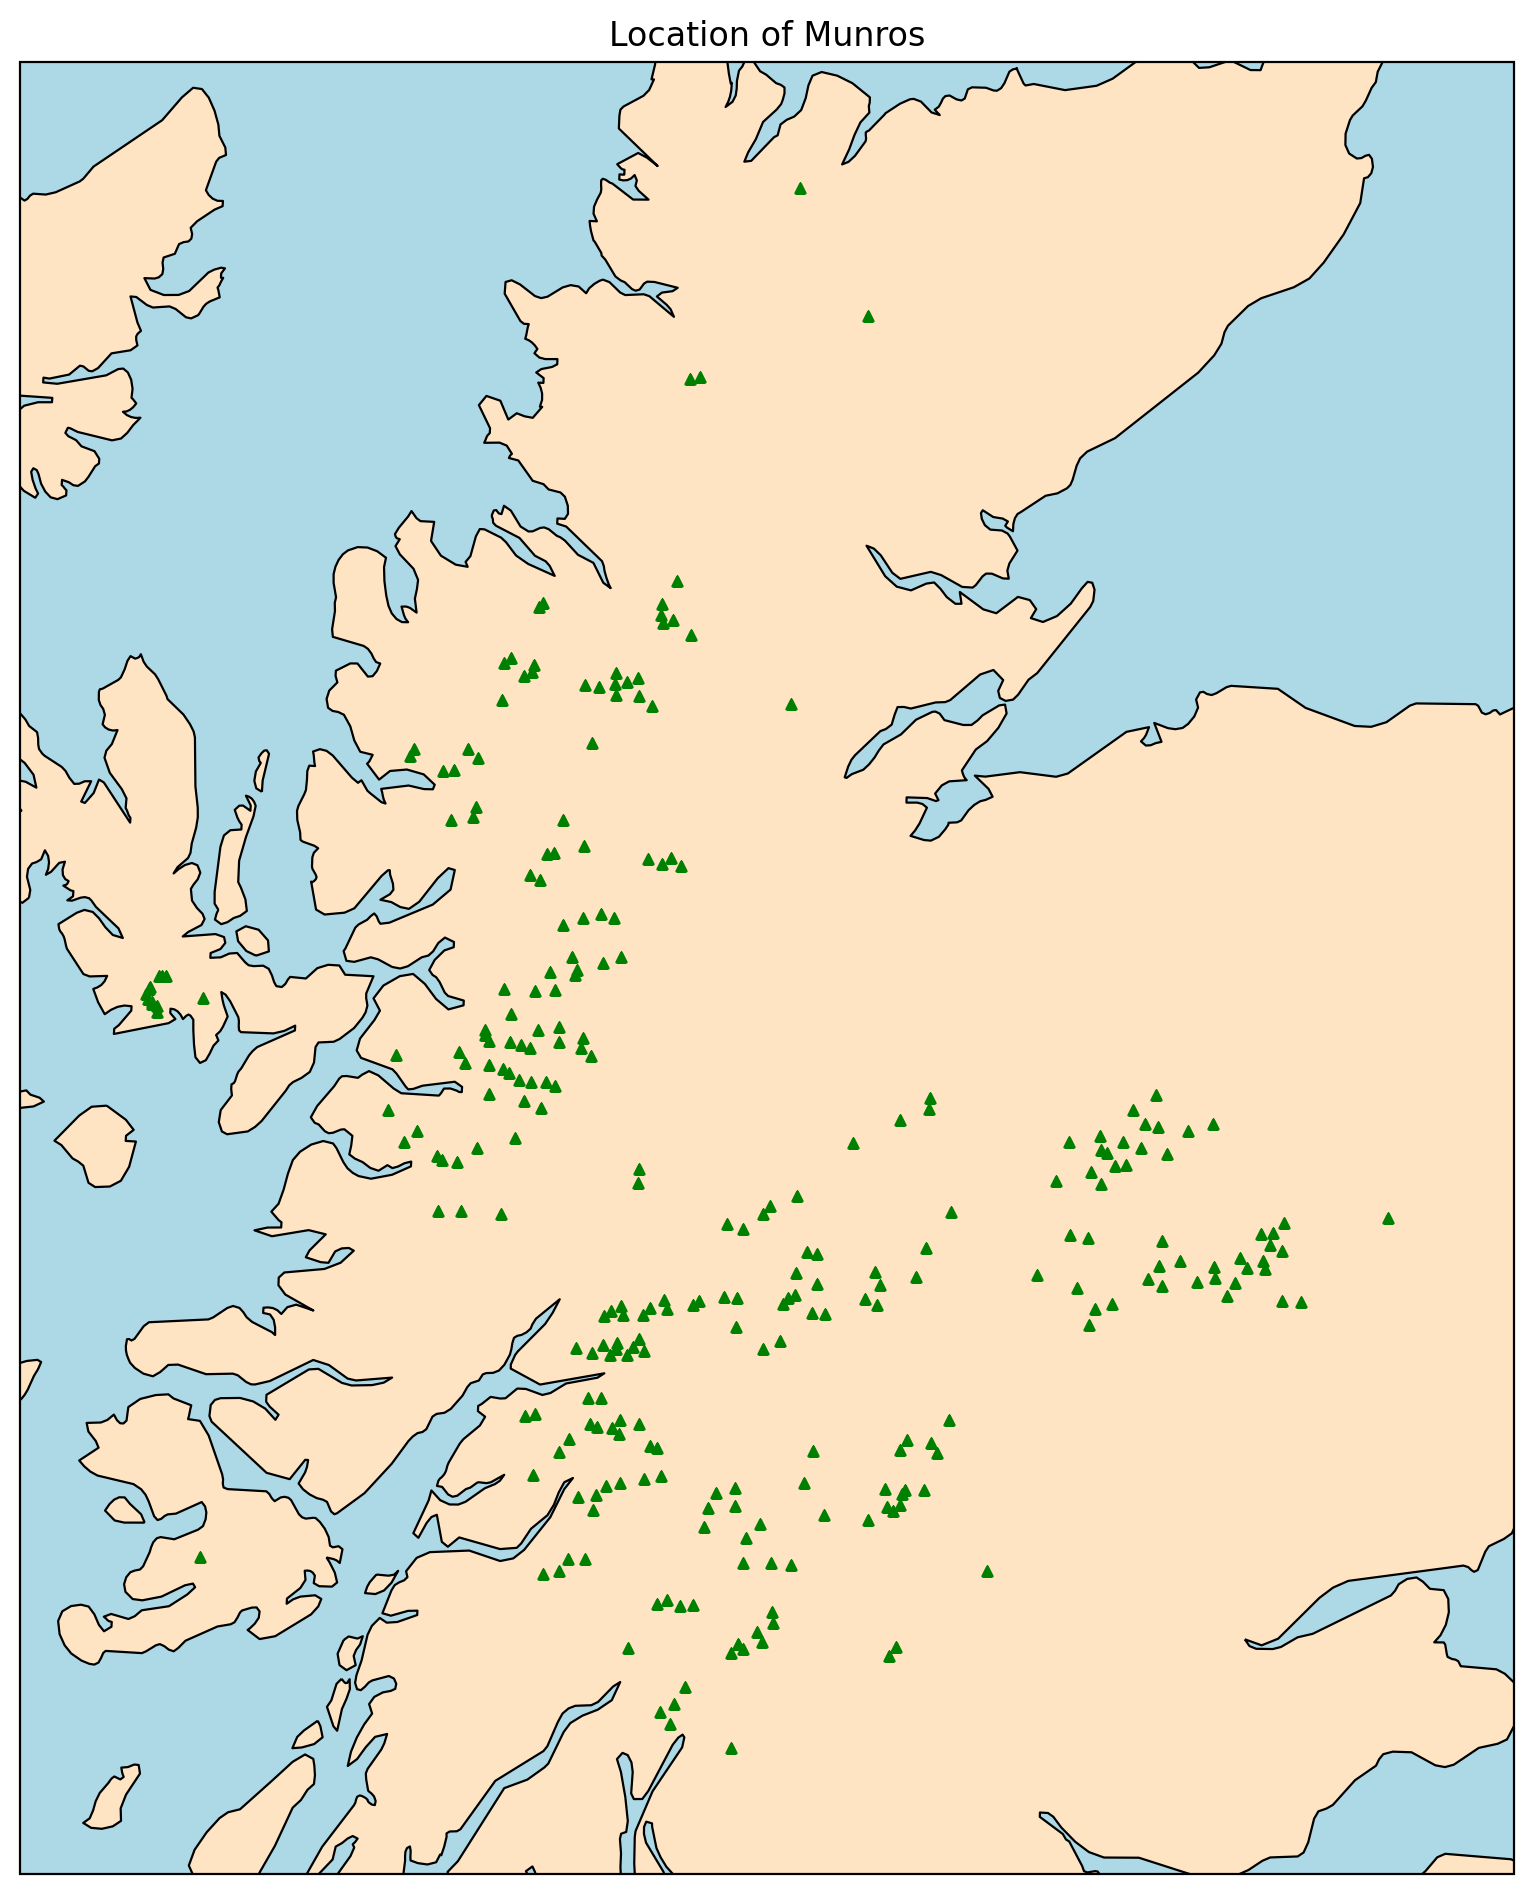

In [4]:
#Function call for plot
plot_scotland_map(munro_locations)

# Testing Algorithms to find the most efficient route
The following algorithms will be tested with an increasing N value.:

Since all the algorithms included in the pyCombinatorial module are solving the TSP which requires returning to the start point, some of the outputs aren't great



# Exact Algorithms
## Brute force:
This algorithm will check every possible route and calculate the total distance to find the minimum. This is extremely inefficient as it has a complexity of O((n-1)!/2). This will work for a *very* small N and is infeasible for all 282 munros. After a few attempts, anything greater than N = 10, takes a LOT of time to execute.
I had never considered using this approach at all, but using it more to illustrate the importance finding a suitable algorithm.
For reference: 281! = 4.713x10^567

The munros should be traversed in the following order 
 ['Ben Chonzie', 'Ben Vorlich', "Stuc a' Chroin", 'Ben Lomond']


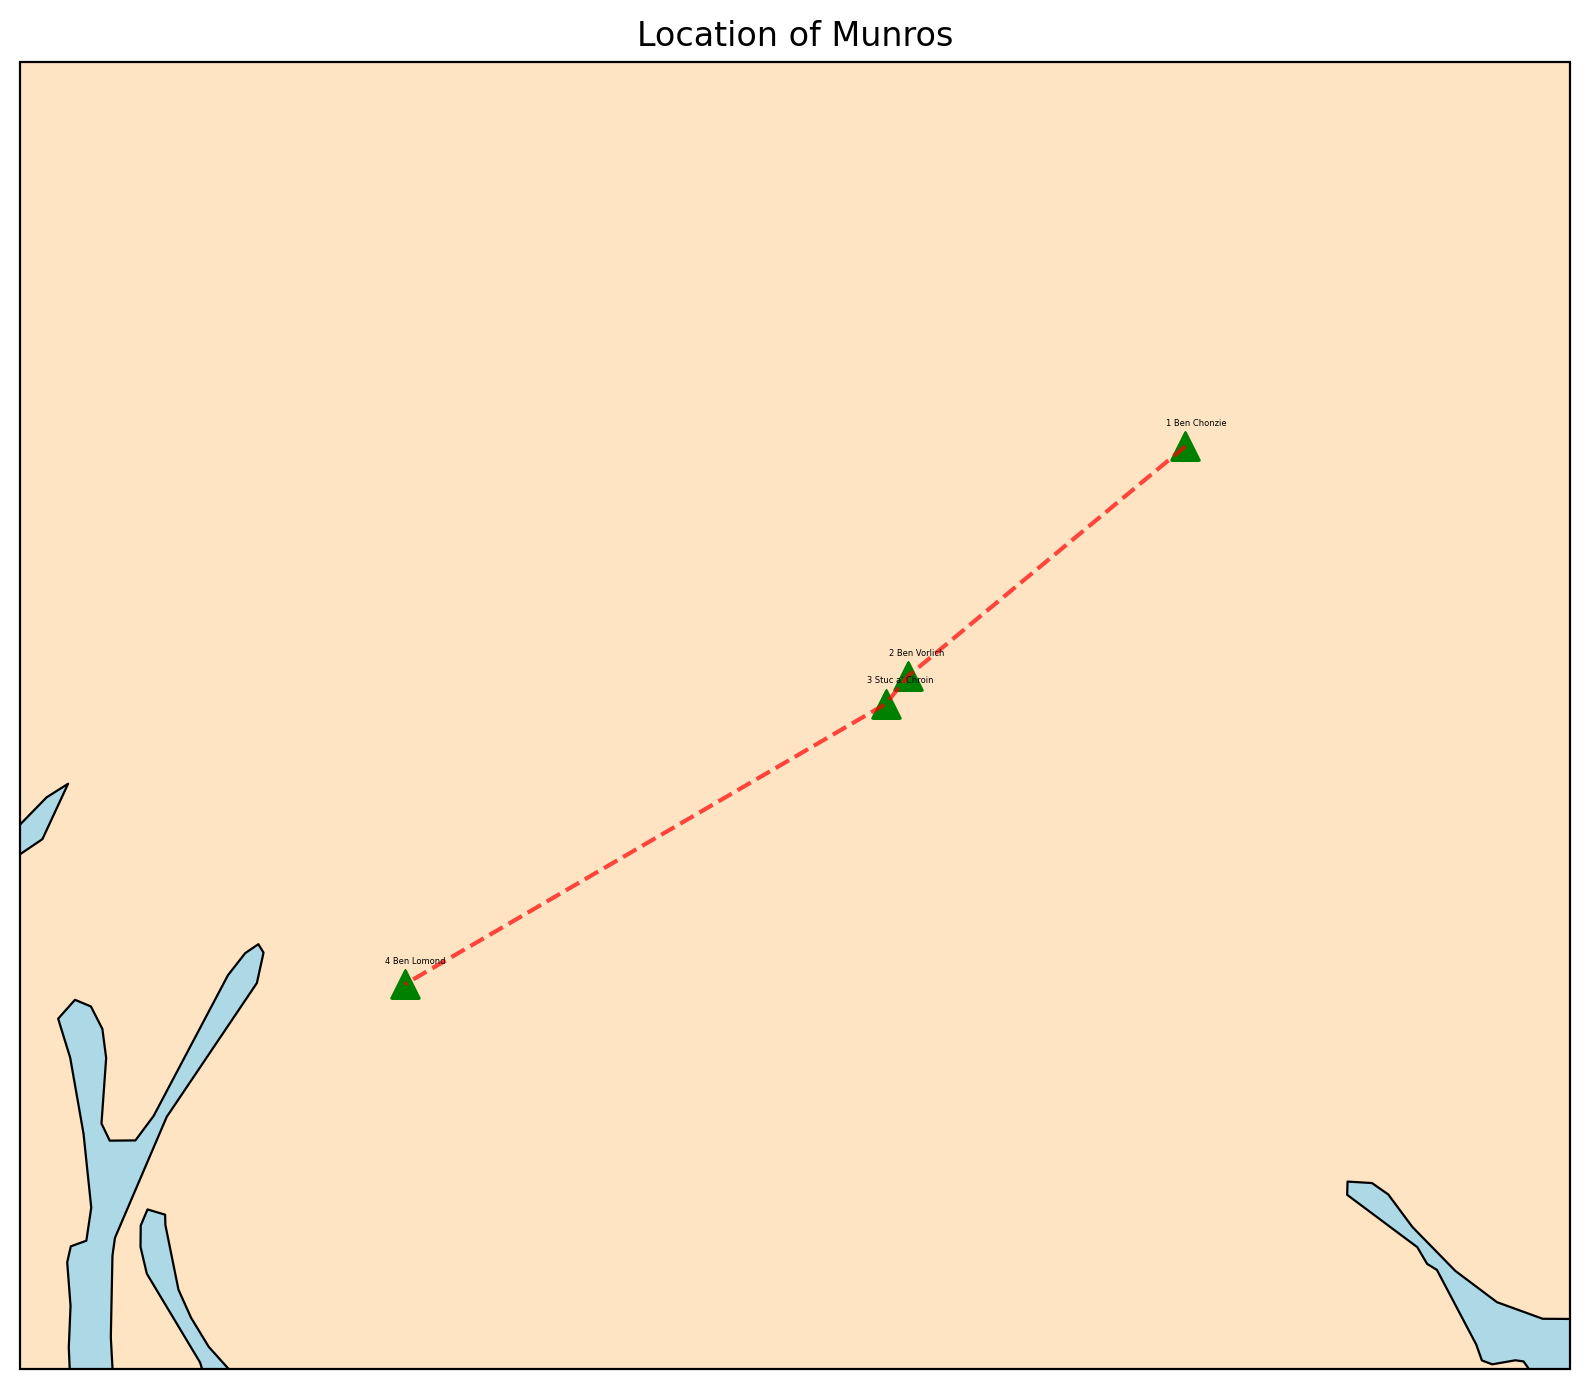

In [100]:
def brute_force(locations):
    n = locations.shape[0]
    permutations = list(range(1, n))
    
    min_distance = np.inf
    best_route = []
    
    for permutation in itertools.permutations(permutations):
        current_tour_indices = [0] + list(permutation) + [0]
        current_distance = 0.0

        for i in range(n):
            munro1_index = current_tour_indices[i]
            munro2_index = current_tour_indices[i+1]

            coord1 = locations[munro1_index]
            coord2 = locations[munro2_index]

            distance = np.linalg.norm(coord1 - coord2, ord=2)
            current_distance += distance

        if current_distance < min_distance:
            min_distance = current_distance
            best_route = current_tour_indices[:-1] 

    return best_route
    
route = brute_force(munro_locations[:5,:])
route_named = [munro_names[i] for i in route[:-1]]
route_coords = [ munro_locations[i] for i in route[:-1]]
print("The munros should be traversed in the following order \n", route_named) 
plot_scotland_map(np.array(route_coords), route_named, True)

## Bellman-Held-Karp Algorithm:
This algorithms, also known as the Dynamic Programming Solution for TSP, breaks down the TSP into smaller sub-problems instead of checking every possible permutation remembering previous shortest paths. Uses a distance matrix very similar to Djikstra's algorithm.


Iteration:  2  of  9  Analysed Combinations:  36
Iteration:  3  of  9  Analysed Combinations:  84
Iteration:  4  of  9  Analysed Combinations:  126
Iteration:  5  of  9  Analysed Combinations:  126
Iteration:  6  of  9  Analysed Combinations:  84
Iteration:  7  of  9  Analysed Combinations:  36
Iteration:  8  of  9  Analysed Combinations:  9
Iteration:  9  of  9  Analysed Combinations:  1
The munros should be traversed in the following order 
 ['Ben Vorlich', "Stuc a' Chroin", 'Ben Lomond', 'Ben More', 'Beinn Tulaichean', 'Beinn Chabhair', "Beinn a' Chroin", 'An Caisteal', 'Cruach Ardrain', 'Stob Binnein']


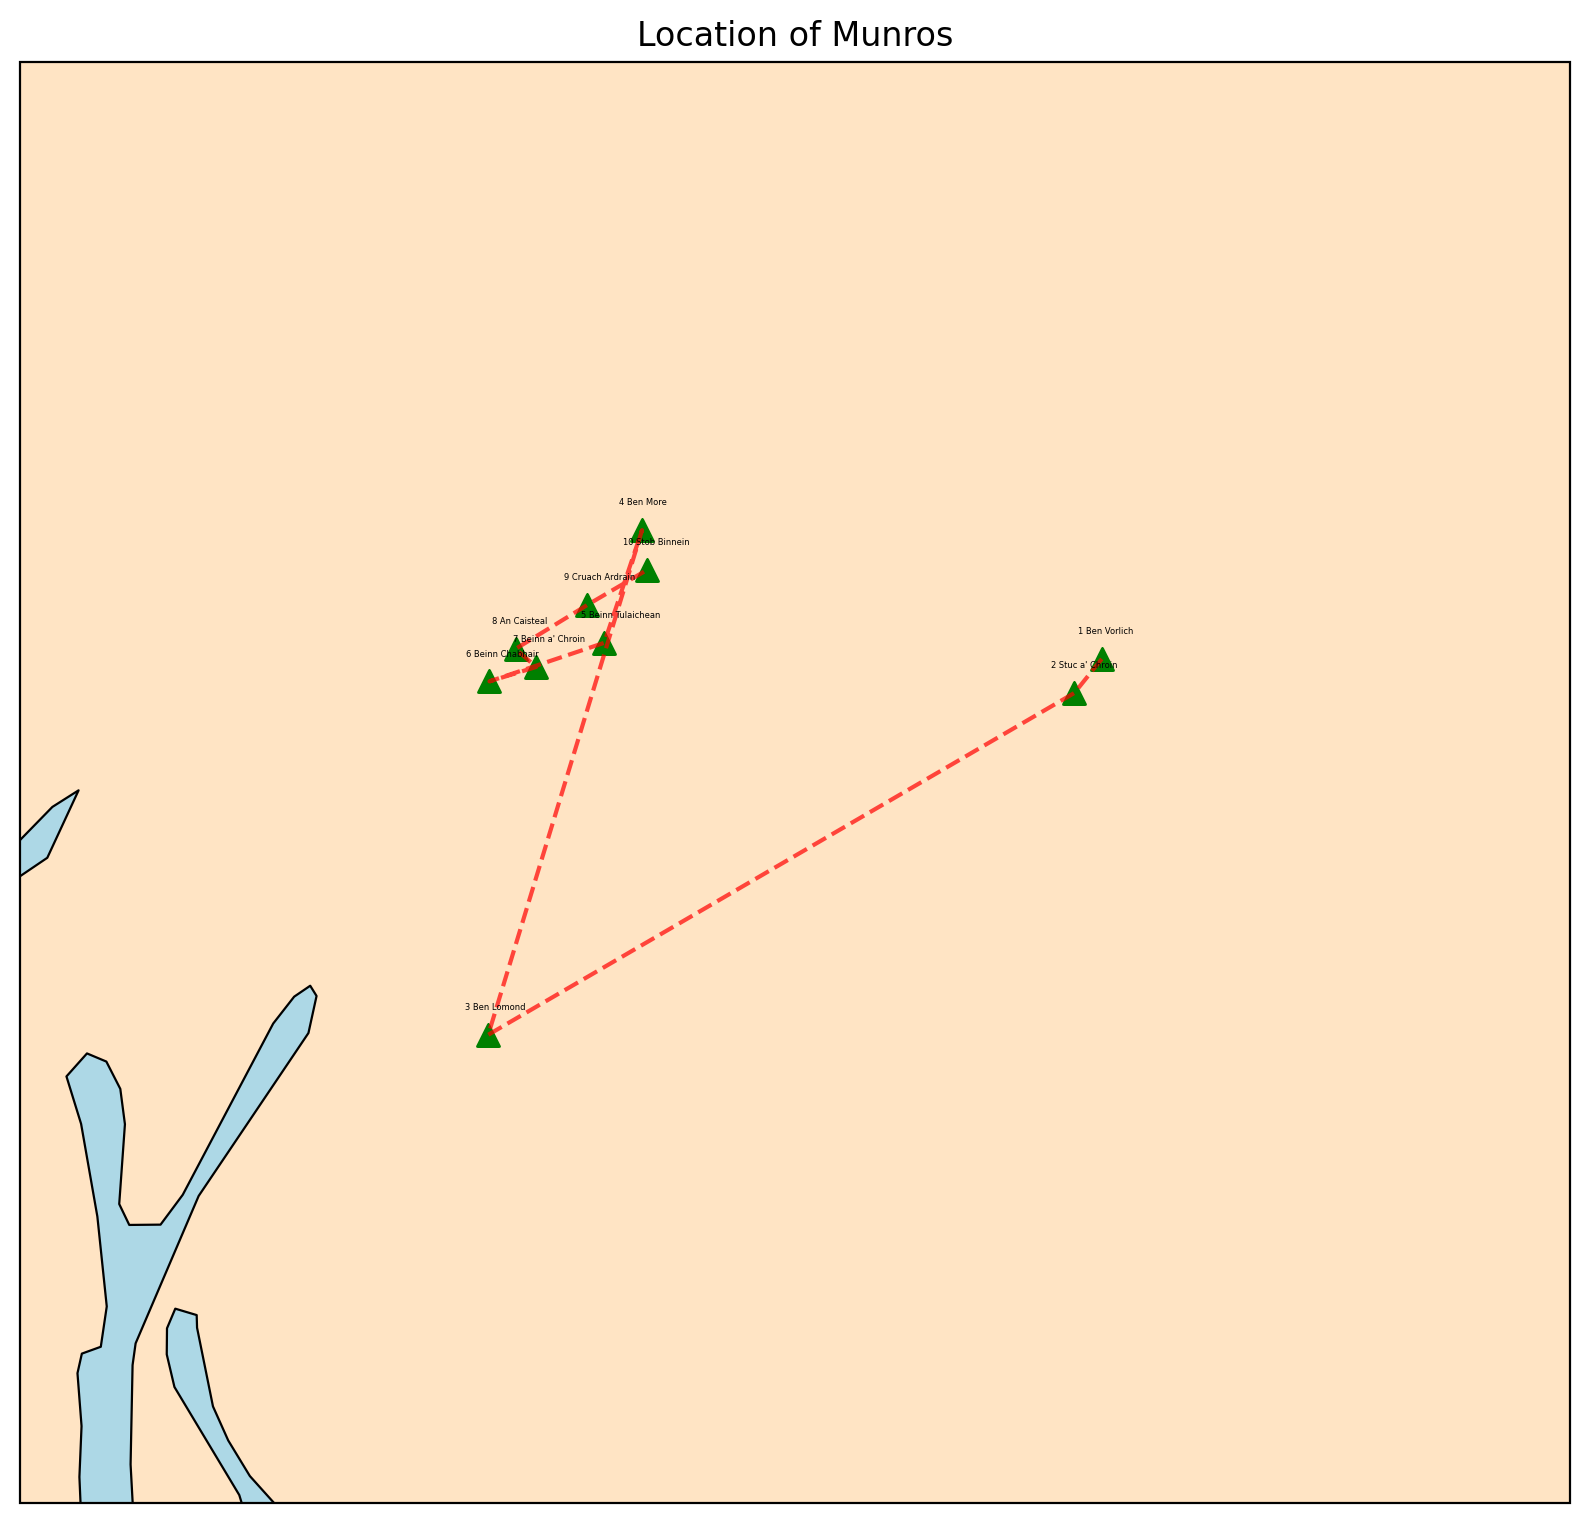

In [7]:
from pyCombinatorial.algorithm import bellman_held_karp_exact_algorithm

n_munros = munro_locations[:10,:]
distance_matrix = util.build_distance_matrix(np.array(n_munros).astype(np.float64))
parameters = { 'verbose': True }
route, distance = bellman_held_karp_exact_algorithm(distance_matrix, **parameters)

#Doing [:-1] slicing because route also includes the start point which we don't want.
route_named = [ munro_names[i] for i in route[:-1]]
route_coords = [ munro_locations[i] for i in route[:-1]]
print("The munros should be traversed in the following order \n", route_named) 
plot_scotland_map(np.array(route_coords), route_named, True)

# Heuristic Algorithms


## Nearest Neighbour Algorithm
This algorithm works by picking the nearest unvisited point from the previous one.
**NOTE: The pyCombinatorial one does not seem to yield a good output and takes much longer to execute than the one implemented myself.**

Iteration =  0 Distance =  1981578.34
Iteration =  1 Distance =  1981578.34
Iteration =  2 Distance =  1981578.34
Iteration =  3 Distance =  1899306.59
Iteration =  4 Distance =  1899306.59
Iteration =  5 Distance =  1899306.59
Iteration =  6 Distance =  1899306.59
Iteration =  7 Distance =  1899306.59
Iteration =  8 Distance =  1899306.59
Iteration =  9 Distance =  1899306.59
Iteration =  10 Distance =  1897452.72
Iteration =  11 Distance =  1888096.05
Iteration =  12 Distance =  1888096.05
Iteration =  13 Distance =  1888096.05
Iteration =  14 Distance =  1885201.12
Iteration =  15 Distance =  1885201.12
Iteration =  16 Distance =  1885201.12
Iteration =  17 Distance =  1885201.12
Iteration =  18 Distance =  1885201.12
Iteration =  19 Distance =  1885201.12
Iteration =  20 Distance =  1885201.12
Iteration =  21 Distance =  1885201.12
Iteration =  22 Distance =  1885201.12
Iteration =  23 Distance =  1885201.12
Iteration =  24 Distance =  1885201.12
Iteration =  25 Distance =  1885201

Iteration =  237 Distance =  1885201.12
Iteration =  238 Distance =  1885201.12
Iteration =  239 Distance =  1885201.12
Iteration =  240 Distance =  1885201.12
Iteration =  241 Distance =  1885201.12
Iteration =  242 Distance =  1885201.12
Iteration =  243 Distance =  1885201.12
Iteration =  244 Distance =  1885201.12
Iteration =  245 Distance =  1885201.12
Iteration =  246 Distance =  1885201.12
Iteration =  247 Distance =  1885201.12
Iteration =  248 Distance =  1885201.12
Iteration =  249 Distance =  1885201.12
Iteration =  250 Distance =  1885201.12
Iteration =  251 Distance =  1885201.12
Iteration =  252 Distance =  1885201.12
Iteration =  253 Distance =  1885201.12
Iteration =  254 Distance =  1885201.12
Iteration =  255 Distance =  1885201.12
Iteration =  256 Distance =  1885201.12
Iteration =  257 Distance =  1885201.12
Iteration =  258 Distance =  1885201.12
Iteration =  259 Distance =  1885201.12
Iteration =  260 Distance =  1885201.12
Iteration =  261 Distance =  1885201.12


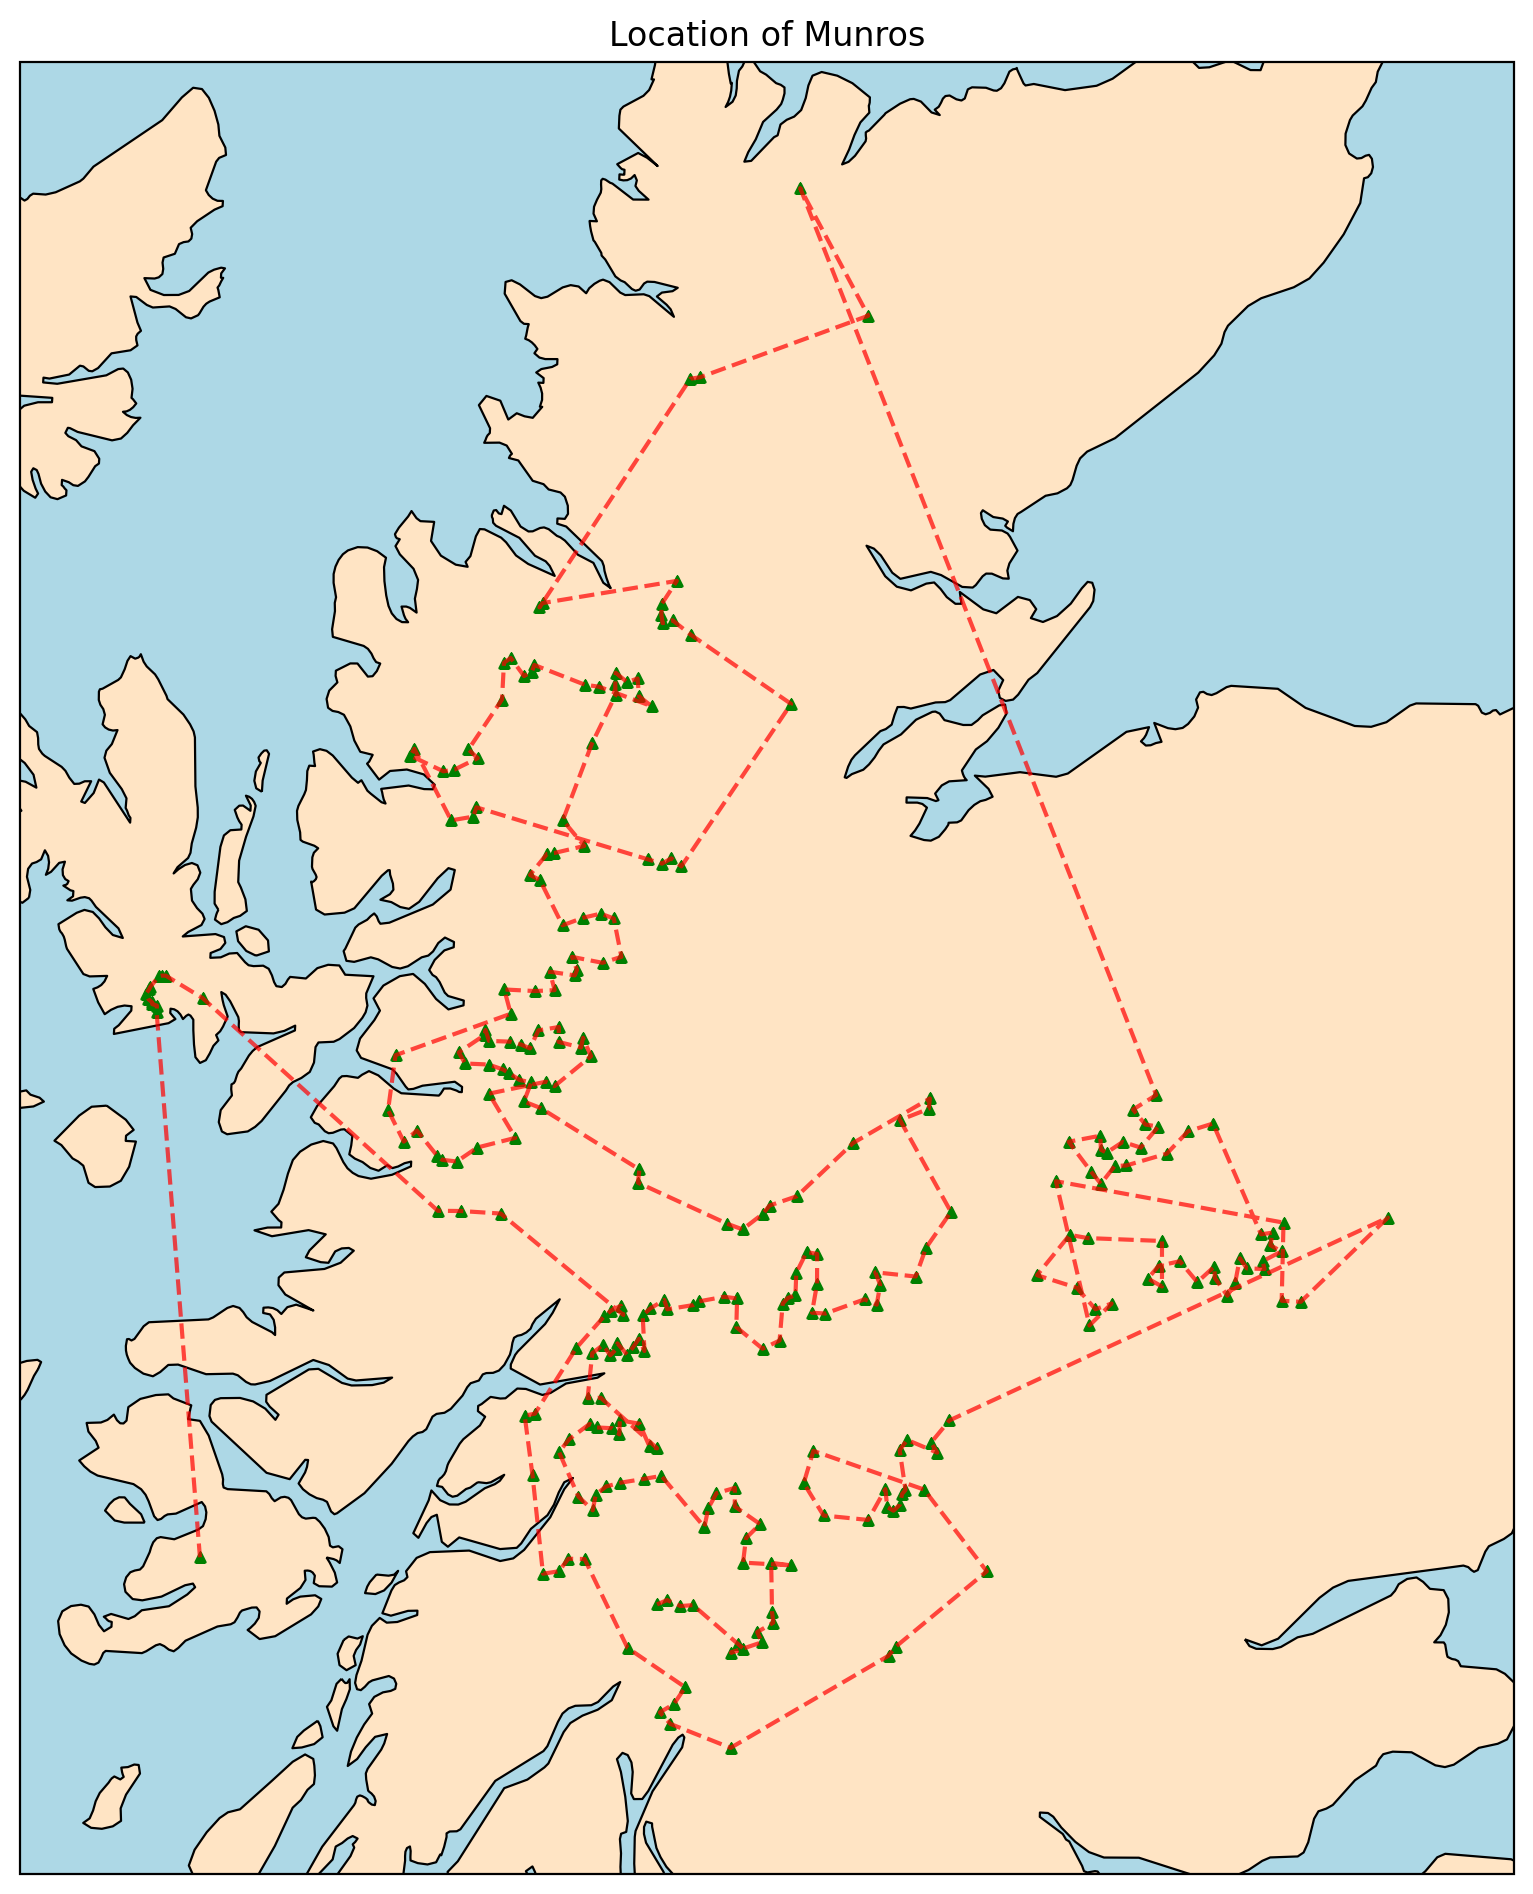

In [25]:
from pyCombinatorial.algorithm import nearest_neighbour

n_munros = munro_locations
distance_matrix = util.build_distance_matrix(np.array(n_munros).astype(np.float64))
parameters = {
            'initial_location': -1, # -1 =  Try All Locations.#           
            'local_search': False, 
            'verbose': True
             }
nn_route, nn_distance = nearest_neighbour(distance_matrix, **parameters)

#Doing [:-1] slicing because route also includes the start point which we don't want.
route_coords = [ munro_locations[i-1] for i in nn_route[:-1]]
plot_scotland_map(np.array(route_coords),[],True)

The munros should be traversed in the following order 
 ['Carn Bhac', 'Beinn Iutharn Mhor', 'Carn an Righ', 'Glas Tulaichean', 'An Socach', "Carn a' Gheoidh", 'The Cairnwell', 'Carn Aosda', 'Glas Maol', 'Creag Leacach', 'Cairn of Claise', 'Carn an Tuirc', 'Tolmount', 'Tom Buidhe', 'Broad Cairn', 'Cairn Bannoch', "Carn a' Choire Bhoidheach", 'Carn an t-Sagairt Mor', 'Cac Carn Beag (Lochnagar)', 'Mayar', 'Driesh', 'Mount Keen', 'Leabaidh an Daimh Bhuidhe (Ben Avon)', "Beinn a' Bhuird North Top", "Beinn a' Chaorainn", 'Beinn Mheadhoin', 'Cairn Gorm', 'Bynack More', 'Derry Cairngorm', 'Ben Macdui [Beinn Macduibh]', 'Cairn Toul', 'Sgor an Lochain Uaine', 'Braeriach', 'Sgor Gaoith', 'Monadh Mor', 'Beinn Bhrotain', "The Devil's Point", "Carn a' Mhaim", 'Beinn Bhreac', "Mullach Clach a' Bhlair", 'Carn an Fhidhleir [Carn Ealar]', 'An Sgarsoch', "Carn a' Chlamain", "Braigh Coire Chruinn-bhalgain (Beinn a' Ghlo)", "Carn nan Gabhar (Beinn a' Ghlo)", "Carn Liath (Beinn a' Ghlo)", 'Beinn Dearg', 'Me

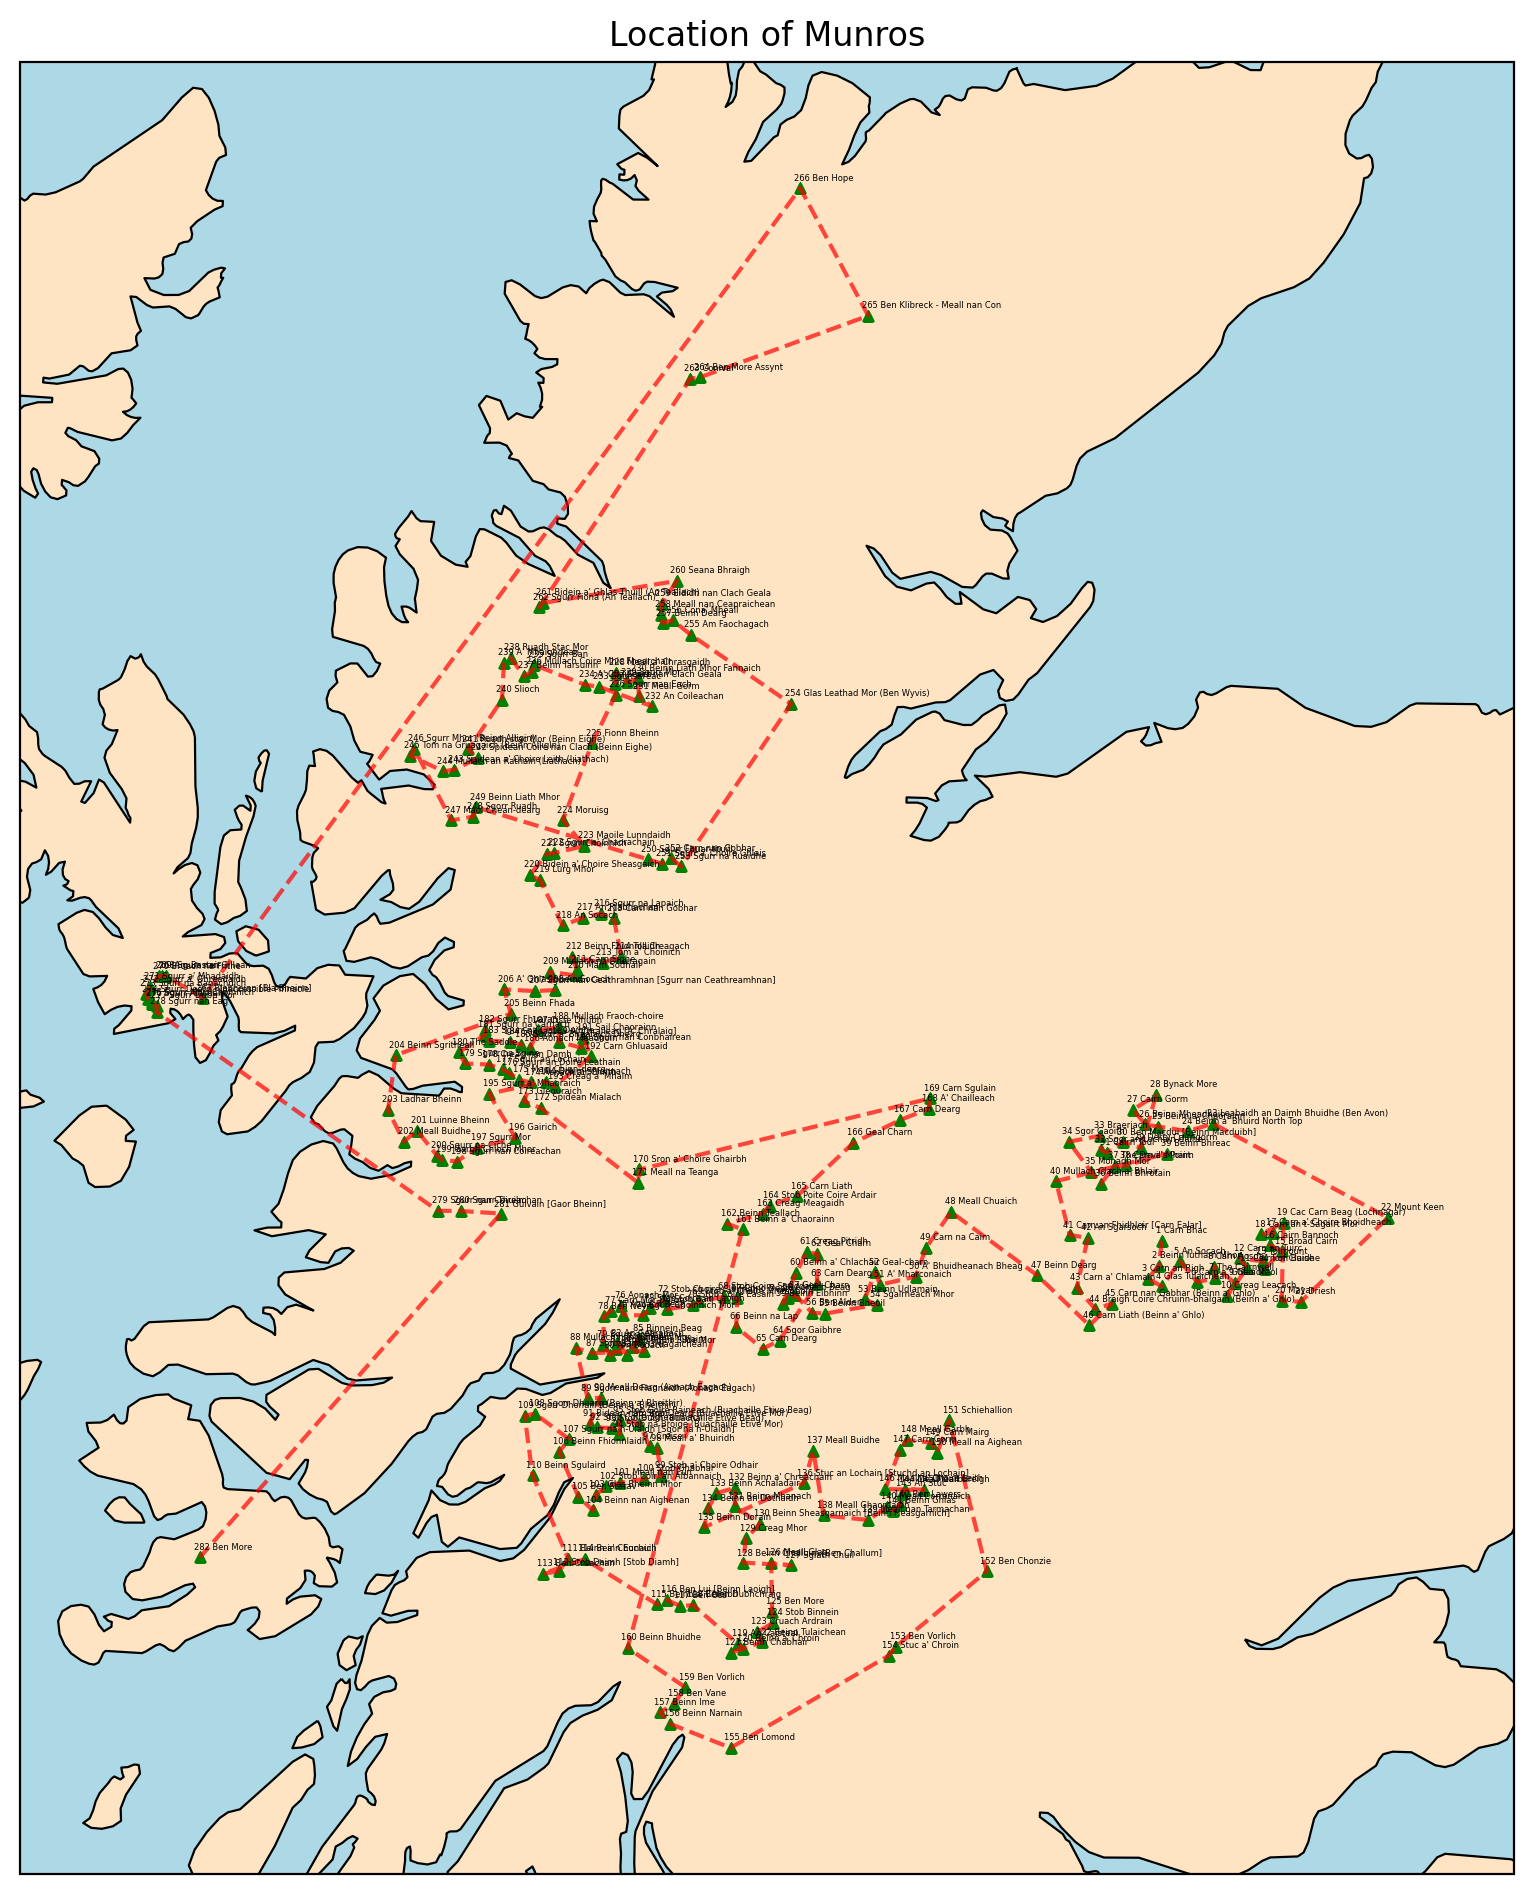

In [33]:
#This cell runs the nearest neighbour algorithm I made.
def nearest_neighbour_path_single_start(coordinates, start_index):
    num_points = coordinates.shape[0]
    if num_points < 2:
        return [0] if num_points == 1 else [], 0.0

    unvisited = set(range(num_points))
    path_indices = []
    total_distance = 0.0
    current_index = start_index
    
    while unvisited:
        unvisited.remove(current_index)
        path_indices.append(current_index)
        
        if not unvisited:
            break
            
        current_coord = coordinates[current_index]
        
        min_distance = np.inf
        next_index = -1
        
        for next_candidate_index in unvisited:
            next_coord = coordinates[next_candidate_index]
            
            distance = np.linalg.norm(current_coord - next_coord)
            
            if distance < min_distance:
                min_distance = distance
                next_index = next_candidate_index
        
        total_distance += min_distance
        current_index = next_index   
    return path_indices, total_distance

def find_shortest_nn_path(coordinates):
    num_points = coordinates.shape[0]
    if num_points == 0:
        return [], 0.0

    min_total_distance = np.inf
    best_path_indices = []

    for start_index in range(num_points):
        
        path_indices, total_distance = nearest_neighbour_path_single_start(
            coordinates, 
            start_index
        )
        if total_distance < min_total_distance:
            min_total_distance = total_distance
            best_path_indices = path_indices
            
    return best_path_indices, min_total_distance

my_nn_route, my_nn_distance = find_shortest_nn_path(munro_locations)
route_named = [ munro_names[i] for i in my_nn_route]
route_coords = [ munro_locations[i] for i in my_nn_route]
print("The munros should be traversed in the following order \n", route_named) 
plot_scotland_map(np.array(route_coords), route_named, True)

## Nearest Insertion

In [28]:
from pyCombinatorial.algorithm import nearest_insertion
n_munros = munro_locations
distance_matrix = util.build_distance_matrix(np.array(n_munros).astype(np.float64))
parameters = {
            'initial_location': -1,
            'verbose': True
             }
ni_route, ni_distance = nearest_insertion(distance_matrix, **parameters)

#Doing [:-1] slicing because route also includes the start point which we don't want.
route_named = [ munro_names[i] for i in ni_route[:-1]]
route_coords = [ munro_locations[i] for i in ni_route[:-1]]
print("The munros should be traversed in the following order \n", route_named) 
plot_scotland_map(np.array(route_coords), route_named, True)

KeyboardInterrupt: 

## Farthest Insertion

In [29]:
from pyCombinatorial.algorithm import farthest_insertion
n_munros = munro_locations
distance_matrix = util.build_distance_matrix(np.array(n_munros).astype(np.float64))
parameters = {
            'initial_location': -1,
            'verbose': True
             }
fi_route, fi_distance = farthest_insertion(distance_matrix, **parameters)

#Doing [:-1] slicing because route also includes the start point which we don't want.
route_named = [ munro_names[i] for i in fi_route[:-1]]
route_coords = [ munro_locations[i] for i in fi_route[:-1]]
print("The munros should be traversed in the following order \n", route_named) 
plot_scotland_map(np.array(route_coords), route_named, True)

KeyboardInterrupt: 

## Cheapest Insertion


In [ ]:
from pyCombinatorial.algorithm import cheapest_insertion

n_munros = munro_locations
distance_matrix = util.build_distance_matrix(np.array(n_munros).astype(np.float64))
parameters = { 'verbose': True }
ci_route, ci_distance = cheapest_insertion(distance_matrix, **parameters)

#Doing [:-1] slicing because route also includes the start point which we don't want.
route_named = [ munro_names[i] for i in ci_route[:-1]]
route_coords = [ munro_locations[i] for i in ci_route[:-1]]
print("The munros should be traversed in the following order \n", route_named) 
plot_scotland_map(np.array(route_coords), route_named, True)

## Ant Colony Optimisation

Iteration = 1, Distance = 114186.37
Iteration = 2, Distance = 111437.08
Iteration = 3, Distance = 111437.08
Iteration = 4, Distance = 111437.08
Iteration = 5, Distance = 111437.08
Iteration = 6, Distance = 111437.08
Iteration = 7, Distance = 111437.08
Iteration = 8, Distance = 111437.08
Iteration = 9, Distance = 111437.08
Iteration = 10, Distance = 111437.08
Iteration = 11, Distance = 111437.08
Iteration = 12, Distance = 111437.08
Iteration = 13, Distance = 111437.08
Iteration = 14, Distance = 111437.08
Iteration = 15, Distance = 111437.08
Iteration = 16, Distance = 111437.08
Iteration = 17, Distance = 111437.08
Iteration = 18, Distance = 111437.08
Iteration = 19, Distance = 111437.08
Iteration = 20, Distance = 111437.08
Iteration = 21, Distance = 111437.08
Iteration = 22, Distance = 111437.08
Iteration = 23, Distance = 111437.08
Iteration = 24, Distance = 111437.08
Iteration = 25, Distance = 111437.08
Iteration = 26, Distance = 111437.08
Iteration = 27, Distance = 111437.08
Iteration 

Iteration = 232, Distance = 111437.08
Iteration = 233, Distance = 111437.08
Iteration = 234, Distance = 111437.08
Iteration = 235, Distance = 111437.08
Iteration = 236, Distance = 111437.08
Iteration = 237, Distance = 111437.08
Iteration = 238, Distance = 111437.08
Iteration = 239, Distance = 111437.08
Iteration = 240, Distance = 111437.08
Iteration = 241, Distance = 111437.08
Iteration = 242, Distance = 111437.08
Iteration = 243, Distance = 111437.08
Iteration = 244, Distance = 111437.08
Iteration = 245, Distance = 111437.08
Iteration = 246, Distance = 111437.08
Iteration = 247, Distance = 111437.08
Iteration = 248, Distance = 111437.08
Iteration = 249, Distance = 111437.08
Iteration = 250, Distance = 111437.08
Iteration = 251, Distance = 111437.08
Iteration = 252, Distance = 111437.08
Iteration = 253, Distance = 111437.08
Iteration = 254, Distance = 111437.08
Iteration = 255, Distance = 111437.08
Iteration = 256, Distance = 111437.08
Iteration = 257, Distance = 111437.08
Iteration = 

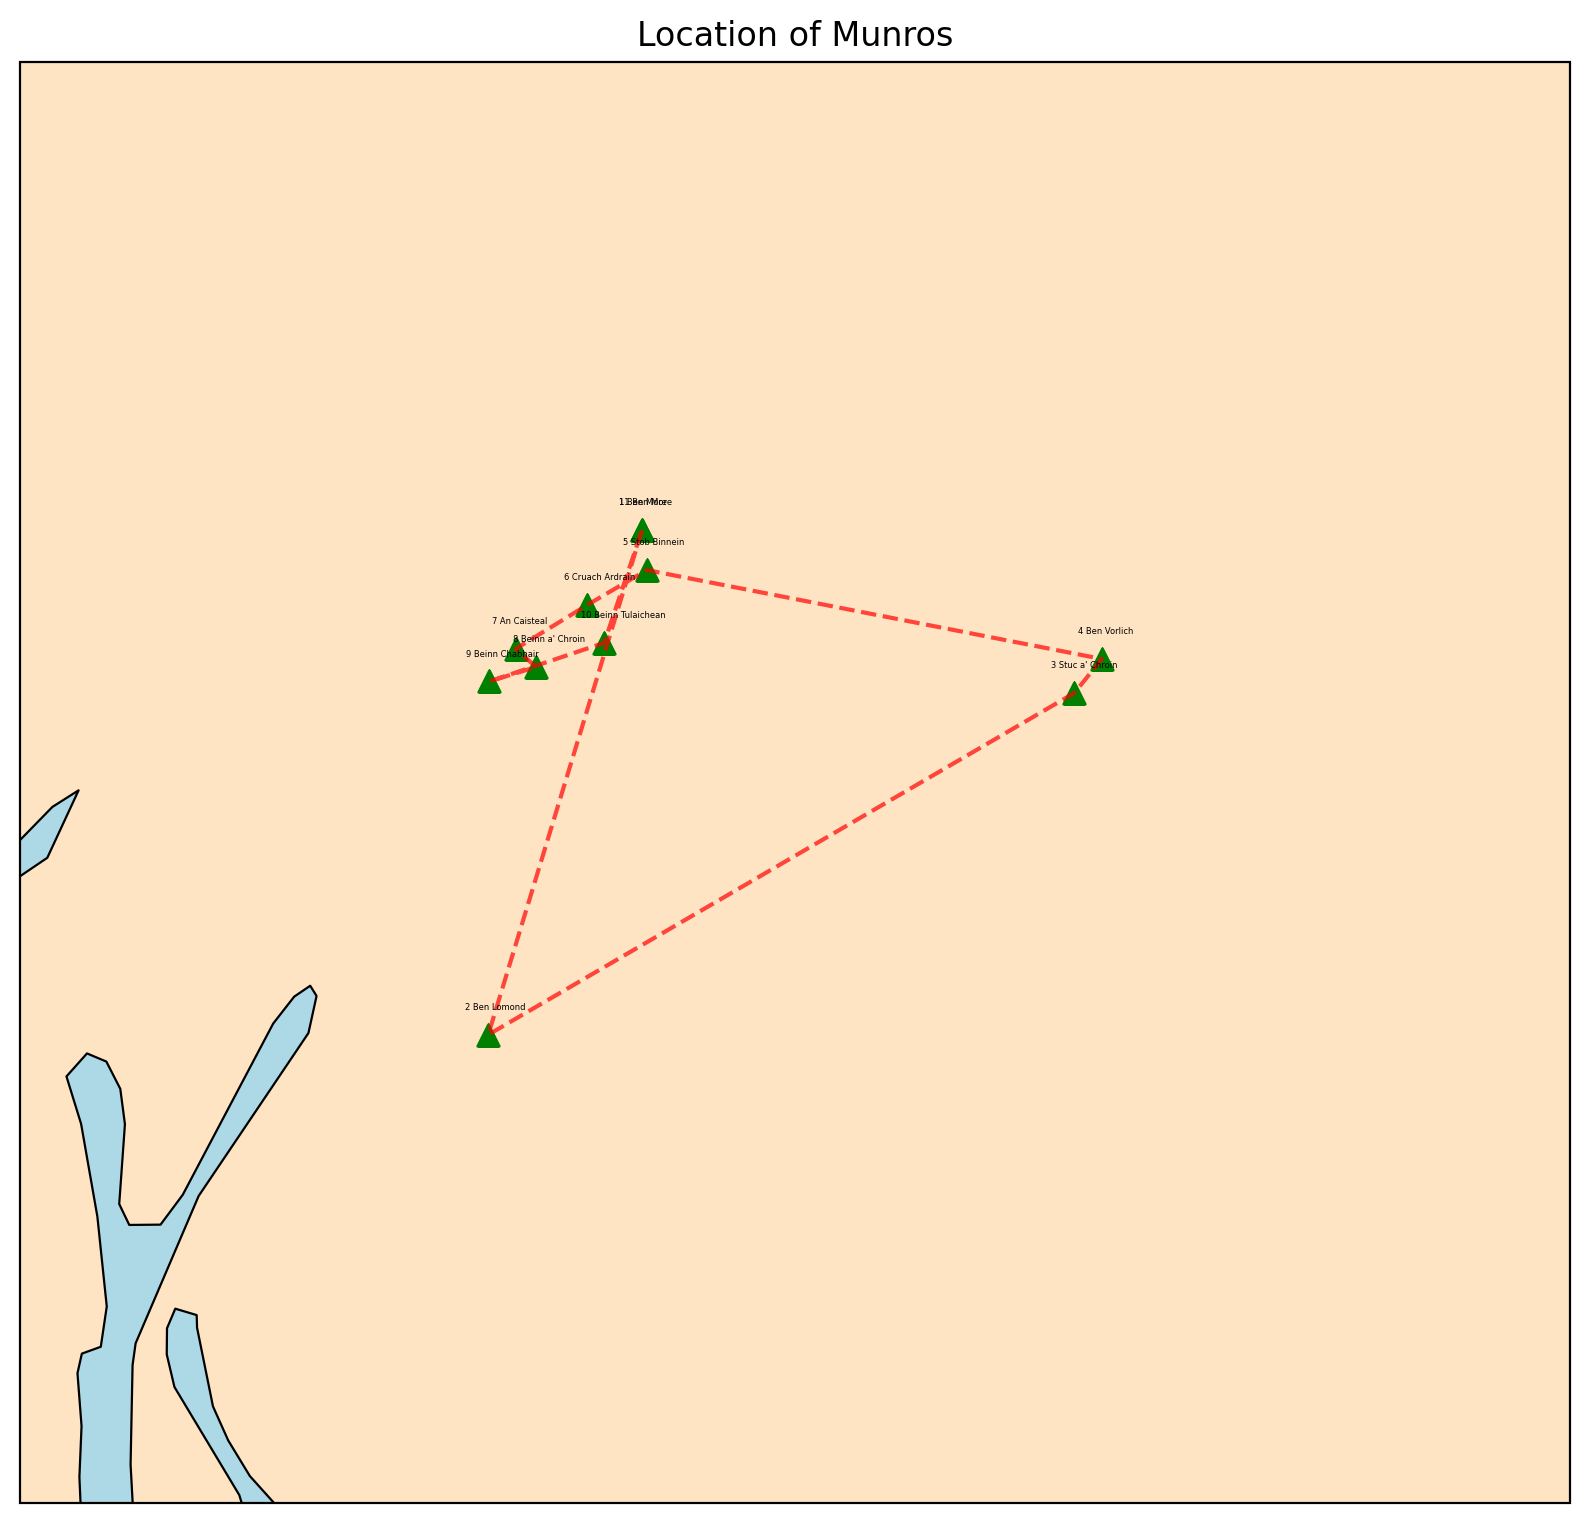

In [31]:
from pyCombinatorial.algorithm import ant_colony_optimization

n_munros = munro_locations[:10,:]
distance_matrix = util.build_distance_matrix(np.array(n_munros).astype(np.float64))
parameters = {
              'ants': 30,
              'iterations': 300,
              'alpha':0.5,
              'beta':2,
              'decay':0.1,
              'local_search': True,
              'verbose': True
             }
ant_route, ant_distance = ant_colony_optimization(distance_matrix, **parameters)
route_named = [ munro_names[i] for i in ant_route]
route_coords = [ munro_locations[i] for i in ant_route]
print("The munros should be traversed in the following order \n", route_named) 
plot_scotland_map(np.array(route_coords), route_named, True)

## 2-opt Algorithm

In [32]:
from pyCombinatorial.algorithm import local_search_2_opt

n_munros = munro_locations
distance_matrix = util.build_distance_matrix(np.array(n_munros).astype(np.float64))
seed = util.seed_function(distance_matrix)
parameters = {
            'recursive_seeding': -1, # Total Number of Iterations. If This Value is Negative Then the Algorithm Only Stops When Convergence is Reached
            'verbose': True
             }
opt_route, opt_distance = local_search_2_opt(distance_matrix, seed, **parameters)

route_named = [ munro_names[i] for i in opt_route]
route_coords = [ munro_locations[i] for i in opt_route]
print("The munros should be traversed in the following order \n", route_named) 
plot_scotland_map(np.array(route_coords), route_named, True)

Iteration =  0 Distance =  21745920.18
Iteration =  1 Distance =  21464274.07
Iteration =  2 Distance =  21162522.52
Iteration =  3 Distance =  20898783.11
Iteration =  4 Distance =  20626699.67
Iteration =  5 Distance =  20357003.05
Iteration =  6 Distance =  20100556.07
Iteration =  7 Distance =  19847225.81
Iteration =  8 Distance =  19605174.59
Iteration =  9 Distance =  19367860.69
Iteration =  10 Distance =  19121992.15
Iteration =  11 Distance =  18890444.81
Iteration =  12 Distance =  18650775.34
Iteration =  13 Distance =  18417132.97
Iteration =  14 Distance =  18188848.21
Iteration =  15 Distance =  17959594.3
Iteration =  16 Distance =  17741855.21
Iteration =  17 Distance =  17525265.13
Iteration =  18 Distance =  17311307.53
Iteration =  19 Distance =  17094424.79
Iteration =  20 Distance =  16871000.06
Iteration =  21 Distance =  16656642.44
Iteration =  22 Distance =  16447855.54
Iteration =  23 Distance =  16234542.7
Iteration =  24 Distance =  16022226.3
Iteration =  

KeyboardInterrupt: 

## 2-opt Algorithm applied to Nearest Neighbour

In [ ]:
from pyCombinatorial.algorithm import local_search_2_opt

distance_matrix = util.build_distance_matrix(np.array(munro_locations).astype(np.float64))
nn_route_indices, nn_distance = find_shortest_nn_path(munro_locations)
seed = [nn_route_indices, nn_distance]
parameters = {
            'recursive_seeding': -1, # Total Number of Iterations. If This Value is Negative Then the Algorithm Only Stops When Convergence is Reached
            'verbose': True
             }
nn_opt_route, nn_opt_distance = local_search_2_opt(distance_matrix, seed, **parameters)

route_named = [ munro_names[i] for i in nn_opt_route]
route_coords = [ munro_locations[i] for i in nn_opt_route]
print("The munros should be traversed in the following order \n", route_named) 
plot_scotland_map(np.array(route_coords), route_named, True)

## Comparing the distances of all algorithms

In [ ]:
print(f"Nearest Neighbour: {nn_distance}")
print(f"My Nearest Neighbour: {my_nn_distance}")
print(f"Nearest Insertion: {ni_distance}")
print(f"Furthest Insertion: {fi_distance}")
print(f"Cheapest Insertion: {ci_distance}")
print(f"Ant Colony: {ant_distance}")
print(f"2 opt: {opt_distance}")
print(f"Nearest neighbour 2 opt {nn_opt_distance}")

In [ ]:
print(f"Nearest Neighbour: {nn_distance}")
print(f"My Nearest Neighbour: {my_nn_distance}")